# Cell-to-Cell Alignment of Mouse Liver Replicates

In this experiment, we align **two liver replicates** from [Animal 2](https://info.vizgen.com/mouse-liver-data), downloaded from Vizgen.  

Each replicate contains over **300,000 cells** and **347 genes**, demonstrating GALA’s ability to efficiently handle **large-scale, cell-resolved datasets** and perform **high-resolution cell-to-cell alignment**.

In [ ]:
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pandas as pd
import time 
import torch
import matplotlib.gridspec as gridspec
import os
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from matplotlib.patches import Rectangle,ConnectionPatch


import warnings
for cat in [FutureWarning, DeprecationWarning]:
    warnings.filterwarnings("ignore", category=cat)

# data loading path
data_path = os.path.expanduser('./Data/MLM')  # Update this path to your data directory  
results_path = os.path.expanduser('./Results')  # Directory to save results
os.makedirs(results_path, exist_ok=True)


# Load data and top three informative gene selection

We designate **Replicate 1** as the **target** and **Replicate 2** as the **source**.  
Following preprocessing, only the top three most informative genes are selected for alignment to reduce noise and computational cost.

In [2]:
from GALA.utils import top_p_genes, process_Merfish_data

# Load MERFISH liver data
L2S1 = sc.read_h5ad(os.path.join(data_path, "L2S1.h5ad")) 
L2S2 = sc.read_h5ad(os.path.join(data_path, "L2S2.h5ad")) 

# Preprocess both replicates (filtering by volume and total counts)
target = process_Merfish_data(L2S1, max_volume=2500, max_counts=3200)
source = process_Merfish_data(L2S2, max_volume=2500, max_counts=3200)

# Identify shared genes and select top informative ones for alignment
shared_gene_names = target.var_names.intersection(source.var_names)
N_GENES = 3
gene_names_to_keep = top_p_genes(source, shared_gene_names, p=N_GENES)

print(f"The selected informative genes are {gene_names_to_keep}")

The selected informative genes are Index(['Aldh1b1', 'Hsd17b6', 'Cyp1a2'], dtype='object')


Plot of raw slices. 

The colour of each cell represents gene expression levels, with lighter colours indicating higher expression values.   For clearer visual comparison in a shared coordinate frame, we display only the spatial locations of cells.

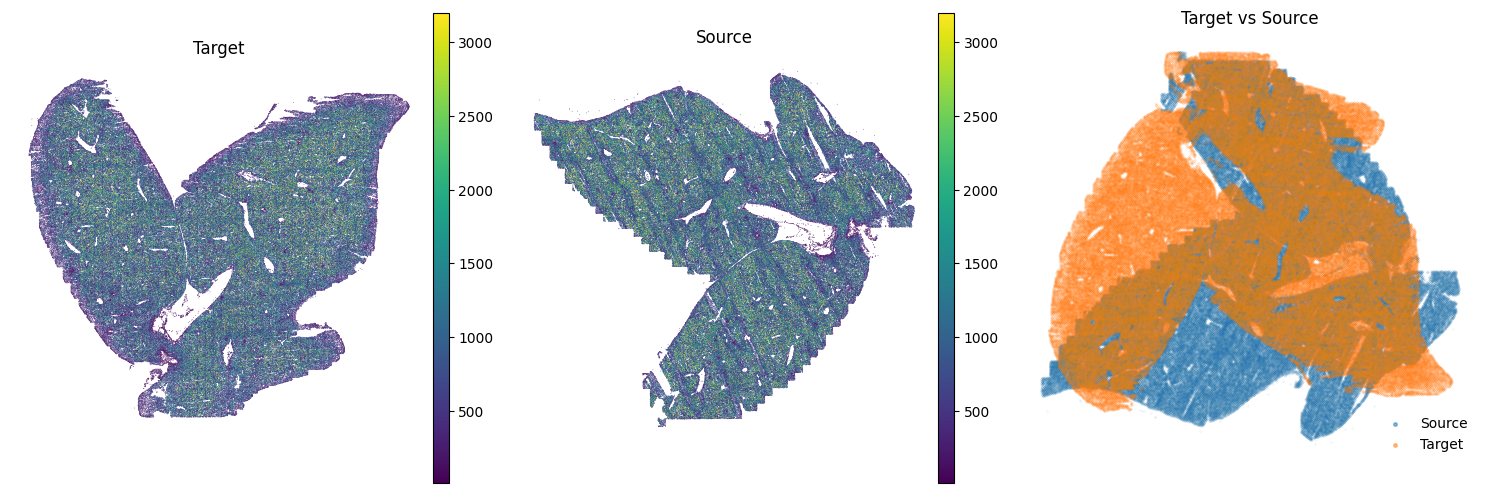

In [3]:
# Visualise raw spatial distributions of the two liver replicates
spatiali = source.obsm['spatial']
spatialj = target.obsm['spatial']
ci = source.obs['total_counts']
cj = target.obs['total_counts']

fig,axs = plt.subplots(1,3,figsize = (15,5))
# Target
sc.pl.embedding(
    target, basis='spatial', color='total_counts',
    size=1, cmap='viridis', frameon=False,
    show=False, ax=axs[0], title='Target',legend_loc= 'right margin'
)
axs[0].set_aspect('equal')
axs[0].axis('off')
# Source
sc.pl.embedding(
    source, basis='spatial', color='total_counts',
    size=1, cmap='viridis', frameon=False,
    show=False, ax=axs[1], title='Source',legend_loc= 'right margin'
)
axs[1].set_aspect('equal')
axs[1].axis('off')
# Stacked raw slices
axs[2].scatter(spatiali[:,0],spatiali[:,1], s= 0.01, alpha=0.5,label = 'Source')
axs[2].scatter(spatialj[:,0],spatialj[:,1],s = 0.01,alpha=0.5,label = 'Target')
axs[2].invert_yaxis()
axs[2].set_title('Target vs Source')
axs[2].set_aspect('equal')
axs[2].axis('off')
axs[2].legend(markerscale=25, loc='lower right', frameon=False)

plt.tight_layout()
plt.show()


# Rasterisation

In the cell-to-cell alignment scenario, only spatial coordinates and gene expression profiles are used for alignment.  
Unlike the spot-based cases incorporating histological images, here each cell’s expression vector is directly rasterised into a spatial grid, forming a molecular field that represents expression intensity across the tissue.

In [4]:
from GALA.utils import rasterize_channel

dx = 30.0
# Expression
X = np.array(source[:,gene_names_to_keep].X.todense())
xi = source.obsm['spatial'][:,0]
yi = source.obsm['spatial'][:,1]
gi = np.array(source.X.sum(axis=1))
si = np.concatenate([X, gi], axis=1)
XI,YI,I = rasterize_channel(xi, yi, si,dx = dx)
# Expression
X = np.array(target[:,gene_names_to_keep].X.todense())
xj = target.obsm['spatial'][:,0]
yj = target.obsm['spatial'][:,1]
gj = np.array(target.X.sum(axis = 1))
sj = np.concatenate([X, gj], axis=1)
XJ,YJ,J = rasterize_channel(xj, yj, sj,dx = dx)

### Coordinate grids
xI = [YI,XI]
xJ = [YJ,XJ]


0 of 300038
10000 of 300038
20000 of 300038
30000 of 300038
40000 of 300038
50000 of 300038
60000 of 300038
70000 of 300038
80000 of 300038
90000 of 300038
100000 of 300038
110000 of 300038
120000 of 300038
130000 of 300038
140000 of 300038
150000 of 300038
160000 of 300038
170000 of 300038
180000 of 300038
190000 of 300038
200000 of 300038
210000 of 300038
220000 of 300038
230000 of 300038
240000 of 300038
250000 of 300038
260000 of 300038
270000 of 300038
280000 of 300038
290000 of 300038
300000 of 300038
300037 of 300038
0 of 310932
10000 of 310932
20000 of 310932
30000 of 310932
40000 of 310932
50000 of 310932
60000 of 310932
70000 of 310932
80000 of 310932
90000 of 310932
100000 of 310932
110000 of 310932
120000 of 310932
130000 of 310932
140000 of 310932
150000 of 310932
160000 of 310932
170000 of 310932
180000 of 310932
190000 of 310932
200000 of 310932
210000 of 310932
220000 of 310932
230000 of 310932
240000 of 310932
250000 of 310932
260000 of 310932
270000 of 310932
280000 o

# GALA

In [5]:
from GALA.gala import gala
from GALA.utils import to_cpu

gene_space=[
        {},                         # angle
        {'low': 1.0, 'high': 1.0},  # sy
        {'low': 1.0, 'high': 1.0},  # sx
        {},  # ty
        {}   # tx
    ]

params = {'num_generations' : 1000,
          'num_iterations': 5000,
          'num_repeats': 2,
          'epV': 10,
          'a': 100,
          'sigmaR':2e5,
          'sigmaM': I.std(),
          'sigmaB': 0.1,
          'random_seed': 42
          }
start = time.time()
resu = gala(xI,I,xJ,J,gene_space = gene_space, **params)
print('Alignment Runtime: ' + str(time.time() - start)) 

# save resu and copy results to CPU if gala runs on GPU.
if torch.cuda.is_available():
    resu = to_cpu(resu)
    
# with open(os.path.join(results_path, "liver.pkl"), 'wb') as f:
#     pickle.dump(resu, f)


Iteration 1 of 2
Generation = 200
Fitness    = 0.00019666799458836897
Change     = 0.00019666799458836897
Generation = 400
Fitness    = 0.00019681436017241434
Change     = 1.4636558404537182e-07
Generation = 600
Fitness    = 0.0001974485646455905
Change     = 6.342044731761645e-07
Generation = 800
Fitness    = 0.00019750951503539715
Change     = 6.095038980664415e-08
Generation = 1000
Fitness    = 0.00019753943295055837
Change     = 2.9917915161221074e-08
Best transformation: angle=113.70, sx=1.00, sy=1.00, tx=-425.13, ty=508.09
0 of 5000
500 of 5000
1000 of 5000
1500 of 5000
2000 of 5000
2500 of 5000
3000 of 5000
3500 of 5000
4000 of 5000
4500 of 5000
4999 of 5000
Iteration 2 of 2
Generation = 200
Fitness    = 0.00019666799458836897
Change     = -8.714383621894015e-07
Generation = 400
Fitness    = 0.00019681436017241434
Change     = 1.4636558404537182e-07
Generation = 600
Fitness    = 0.0001974485646455905
Change     = 6.342044731761645e-07
Generation = 800
Fitness    = 0.000197509515

# Result Analysis
Load previously saved results if we choose to skip running the alignment optimization.

In [6]:
# load results
with open(os.path.join(results_path, "liver.pkl"), 'rb') as f:
   resu = pickle.load(f)

## Convergence of Energy Function 

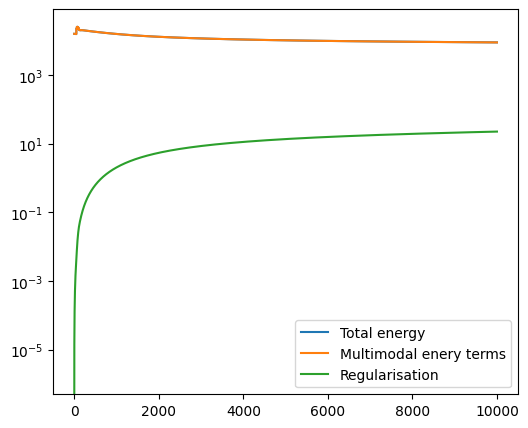

Initial energy for Total energy 16005.030061954898, multimodal energy terms 16005.030061954898, and regularisation 0.0
Final energy for Total energy 9007.168468869211, multimodal energy terms 8984.465965733107, and regularisation 22.702503136103974


In [7]:
E = resu['E']
fig, ax = plt.subplots(figsize = (6,5))
ax.plot(E)
ax.legend(['Total energy','Multimodal enery terms','Regularisation'])
ax.set_yscale('log')
plt.show()

print(f'Initial energy for Total energy {E[0][0]}, multimodal energy terms {E[0][1]}, and regularisation {E[0][2]}')
print(f'Final energy for Total energy {E[-1][0]}, multimodal energy terms {E[-1][1]}, and regularisation {E[-1][2]}')

## Affine vs GALA Alignment

This figure compares the alignment of the source replicate to the target replicate:

- **Left panel:** Source transformed using only the affine component from GA.  
- **Right panel:** Source after full GALA alignment.  

The comparison illustrates how GALA refines global affine transformation with local deformations to achieve accurate cell-to-cell correspondence.


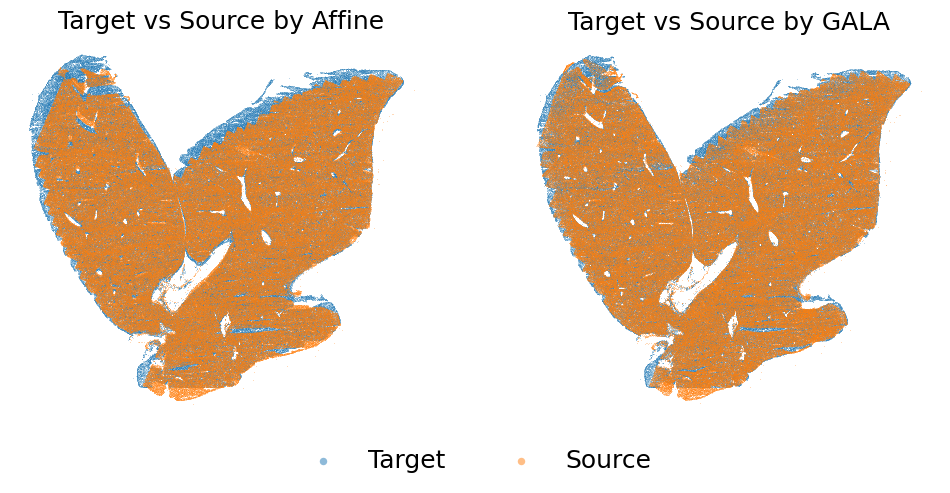

In [8]:
from GALA.utils import alignedada

fs = 18
fs0 = 12
alpha = 0.5
ps = 0.8
markersize = 12

# Compute coordinates by GA (affine)
A = resu['A']
L = A[:2,:2].numpy()
T = A[:2,-1].numpy()
affine = np.dot(L,[spatiali[:,1], spatiali[:,0]]) + np.array([T[0],T[1]])[:,np.newaxis]
spatial0 = np.stack([affine[1, :], affine[0, :]], axis=1)
affine_source = source.copy()
affine_source.obsm['spatial'] = spatial0
# Compute coordinates by full GALA
aligned_source = alignedada(resu,source)
aligned_source.obsm['spatial'] = aligned_source.obsm['aligned']
spatial = aligned_source.obsm['spatial']

fig,axs = plt.subplots(1,2,figsize = (12,5))
# Target vs Affine transformed Source
axs[0].scatter(spatialj[:,0], spatialj[:, 1],s=ps, alpha=alpha, label='Target',linewidth = 0,marker='.')
axs[0].scatter(spatial0[:,0],spatial0[:,1],s=ps, alpha=alpha, label='Source',linewidth = 0,marker='.')
axs[0].set_title('Target vs Source by Affine',size = fs)
axs[0].axis('off')
axs[0].set_aspect('equal')
x0,x1 = 100,9500
y0,y1 = 5500,8500
# rect = Rectangle((x0, y0),               
#             x1 - x0,                
#             y1 - y0,                
#             linewidth=1,
#             edgecolor='red',linestyle='--',   
#             facecolor='none',zorder = 10)
# axs[0].add_patch(rect)


# Target vs Aligned Source
axs[1].scatter(spatialj[:, 0], spatialj[:, 1],s=ps, alpha=alpha, label='Target',linewidth = 0,marker='.')
axs[1].scatter(spatial[:, 0], spatial[:, 1],s=ps, alpha=alpha, label='Source',linewidth = 0,marker='.')
axs[1].set_title('Target vs Source by GALA',size = fs)
axs[1].axis('off')
axs[1].set_aspect('equal')
# rect = Rectangle((x0, y0),               
#         x1 - x0,                
#         y1 - y0,                
#         linewidth=1,
#         edgecolor='red',linestyle='--',   
#         facecolor='none',zorder = 10)
# axs[1].add_patch(rect)

# legend
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc='upper center',
    bbox_to_anchor=(np.mean([axs[0].get_position().x0, axs[1].get_position().x1]),
                    axs[0].get_position().y0 - 0.01),  
    ncol=len(labels),
    fontsize=fs,
    markerscale=markersize,
    frameon=False
)

    

## Zoomed Gene-level Alignment Comparison
This figure illustrates the alignment quality for three highly informative genes across the liver replicates:

- **Top row:** Source after affine transformation (GA) vs target.  
- **Bottom row:** Source after full GALA alignment vs target.  

Each pair shows the source (left) and target (right) in a zoomed-in region, highlighting how GALA improves local cell-to-cell correspondence beyond the global affine transformation.

In [9]:
# define function to find high-expression coordinates 
def coords_high(adata,gene,min_log_expr= 1.0):
    coords = adata.obsm['spatial']         
    expr = adata[:, gene].X
    expr = expr.toarray().flatten() if hasattr(expr, "toarray") else expr.flatten()
    mask_high = expr > min_log_expr       # Boolean mask for high expression
    coords_high = coords[mask_high]
    return(coords_high)

# define plot function
def plot_zoom_in_out(spatiali,spatialj,gene,ax,x0,x1,y0,y1,ps1 = 1,ps2 = 1,alpha = 1):
    ax[0].scatter(spatialj[:, 0], spatialj[:, 1],s=ps1, alpha=alpha, linewidth = 0,marker='.')
    ax[0].scatter(spatiali[:, 0], spatiali[:, 1],s=ps1, alpha=alpha, linewidth = 0,marker='.')
    ax[0].set_aspect('equal')
    # ax.legend(markerscale=20, loc='lower right', frameon=False)
    ax[0].set_title(f'{gene}',fontstyle = 'italic',size = fs)
    ax[0].axis('off')
    rect = Rectangle((x0, y0),x1 - x0, y1 - y0,
                     linewidth=2,edgecolor='red', facecolor='none',zorder = 10)
    ax[0].add_patch(rect)
    # Affine slices
    ax[1].scatter(spatialj[:, 0], spatialj[:, 1],s=ps2, alpha=alpha, linewidth = 0,marker='.')
    ax[1].scatter(spatiali[:, 0], spatiali[:, 1],s=ps2, alpha=alpha, linewidth = 0,marker='.')
    ax[1].axis('off')
    ax[1].set_xlim(x0, x1)
    ax[1].set_ylim(y0, y1)
    ax[1].set_aspect('equal')

    y_top    = max(y0, y1)
    y_bottom = min(y0, y1)
    x_right  = x1
    xlim = ax[1].get_xlim()
    ylim = ax[1].get_ylim()
    width = xlim[1] - xlim[0]
    height = ylim[1] - ylim[0]
    rect_zoom = Rectangle(
        (xlim[0], ylim[0]),  
        width,
        height,
        linewidth=2,
        edgecolor='red',
        facecolor='none'
    )
    ax[1].add_patch(rect_zoom)

    con1 = ConnectionPatch(xyA=(x_right, y_top), coordsA="data", axesA=ax[0],
                       xyB=(0, 1), coordsB="axes fraction", axesB=ax[1],
                       arrowstyle='-', linestyle='--',linewidth=1, color='0.5')
    con2 = ConnectionPatch(xyA=(x_right, y_bottom), coordsA="data", axesA=ax[0],
                        xyB=(0, 0), coordsB="axes fraction", axesB=ax[1],
                        arrowstyle='-', linestyle='--',linewidth=1, color='0.5')

    con1.set_clip_on(False)
    con2.set_clip_on(False)
    ax[1].add_artist(con1)
    ax[1].add_artist(con2)
###
### Retrieve common marker genes
###
# Load a curated table of marker genes, where the index is gene names and one column contains the 'Function' annotation
marker_genes = pd.read_excel(os.path.join(data_path, 'gene_marker.xlsx'),header= 1)
marker_genes = marker_genes.iloc[:,0:2]
marker_genes['Gene name'] = marker_genes['Gene name'].astype(str) 
# Identify common genes present in both source and target
common_genes = list(set(marker_genes['Gene name']) & set(source.var_names) & set(target.var_names)) 
common_genes += ['Aldh1b1', 'Hsd17b6', 'Cyp1a2']
# Final gene list for plotting, including highly informative genes
gene_names =  np.concatenate([['Axin2','Vwf'], gene_names_to_keep])

/tmp/ipykernel_21221/2286467623.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


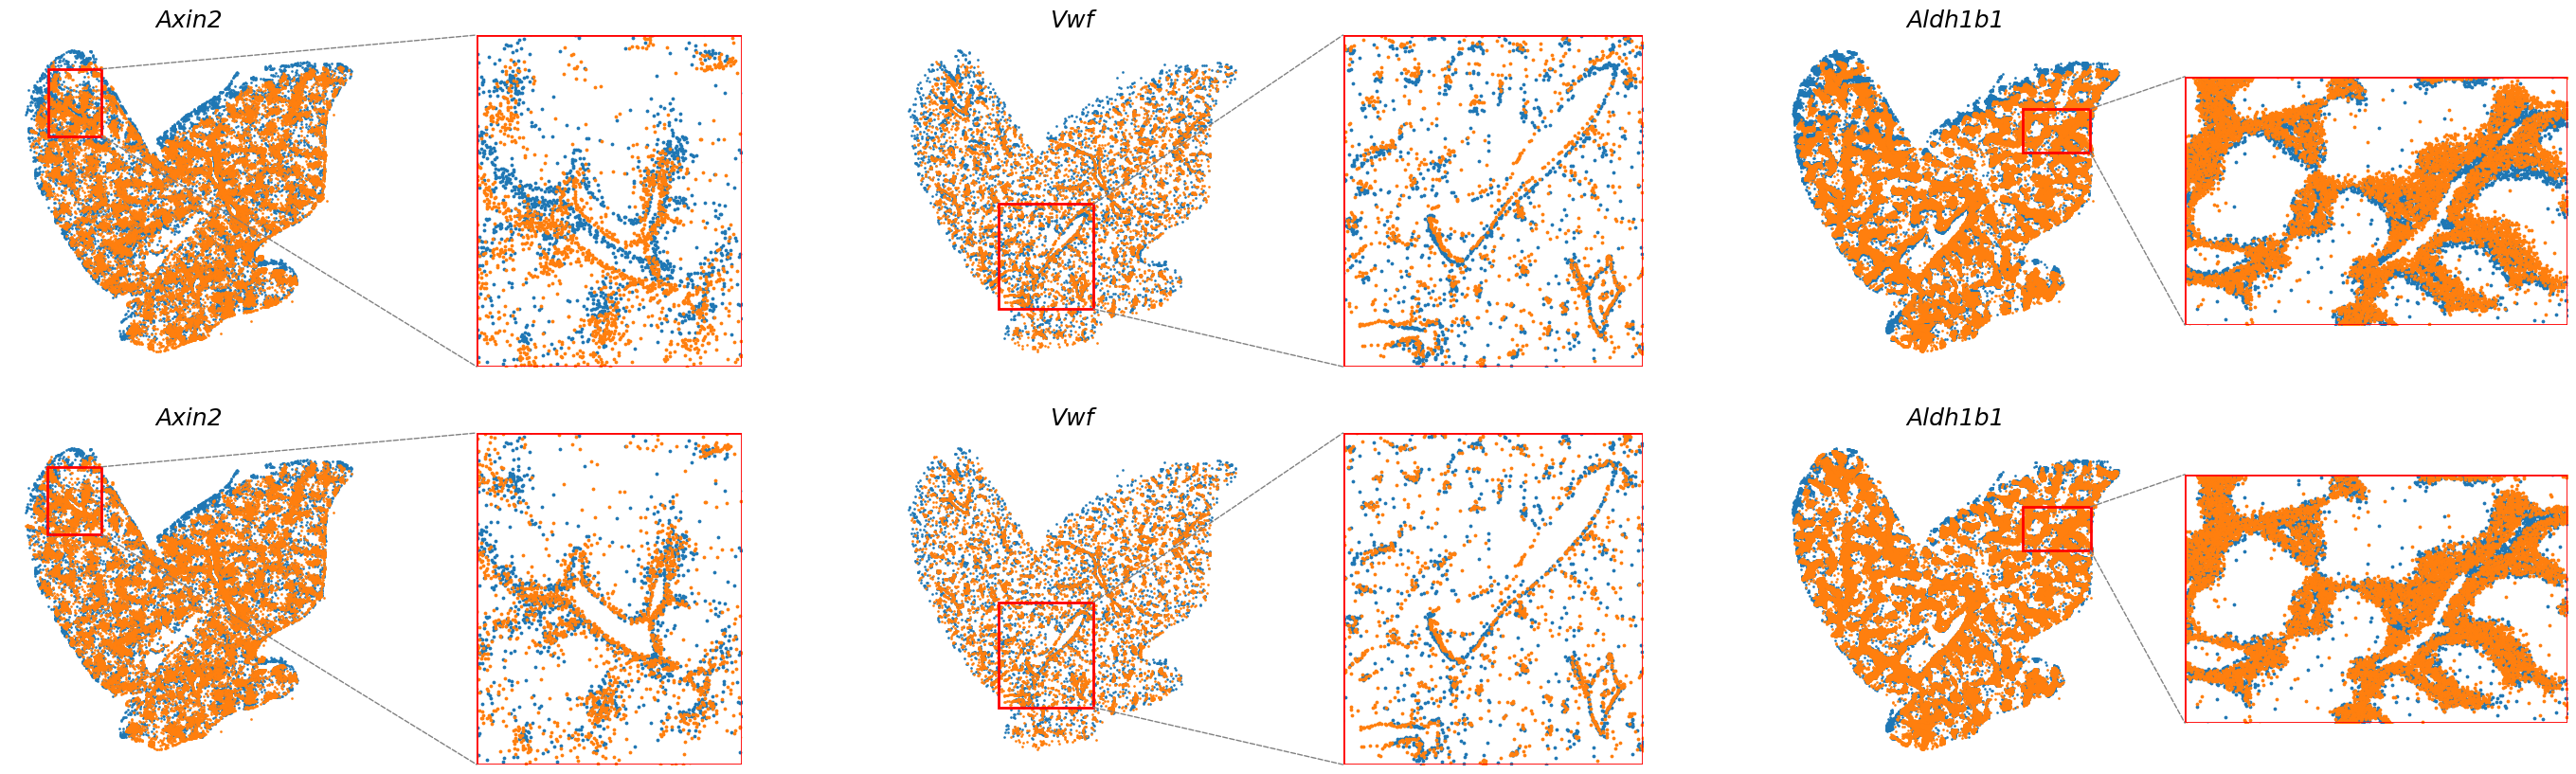

In [10]:
# Zoomed comparison of Affine vs GALA alignment for individual genes
fs = 18
ps1 = 15
ps2 = 30

fig = plt.figure(figsize=(35,10))
gs = GridSpec(2, 3, figure=fig, wspace=0.1)
### Affine transformation
# gene 1
gs1 = GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[0,0],wspace=0.1)
ax_d1 = [fig.add_subplot(gs1[i]) for i in range(2)]
gene = gene_names[0]
coordj = coords_high(target, gene)
coord0 = coords_high(affine_source,gene)
plot_zoom_in_out(coord0,coordj,gene,ax = ax_d1,x0 = 800,x1 = 2400,y0 = 6000,y1= 8000,ps1 = ps1,ps2 = ps2,alpha = 1)
# gene2
gs2 = GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[0,1],wspace=0.1)
ax_d2 = [fig.add_subplot(gs2[i]) for i in range(2)]
gene = gene_names[1]
coordj = coords_high(target, gene)
coord0 = coords_high(affine_source,gene)
plot_zoom_in_out(coord0,coordj,gene,ax = ax_d2,x0 = 2800,x1 = 5600,y0 = 900,y1= 4000,ps1 = ps1,ps2 = ps2,alpha = 1)
# gene3
gs3 = GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[0,2],wspace=0.1)
ax_d3 = [fig.add_subplot(gs3[i]) for i in range(2)]
gene = gene_names[2]
coordj = coords_high(target, gene)
coord0 = coords_high(affine_source,gene)
plot_zoom_in_out(coord0,coordj,gene,ax = ax_d3,x0 = 7000,x1 = 9000,y0 = 5500,y1= 6800,ps1 = ps1,ps2 = ps2,alpha = 1)

### GALA
# gene 1
# gene 1
gs1 = GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[1,0],wspace=0.1)
ax_d1 = [fig.add_subplot(gs1[i]) for i in range(2)]
gene = gene_names[0]
coordj = coords_high(target, gene)
coord0 = coords_high(aligned_source,gene)
plot_zoom_in_out(coord0,coordj,gene,ax = ax_d1,x0 = 800,x1 = 2400,y0 = 6000,y1= 8000,ps1 = ps1,ps2 = ps2,alpha = 1)
# gene2
gs2 = GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[1,1],wspace=0.1)
ax_d2 = [fig.add_subplot(gs2[i]) for i in range(2)]
gene = gene_names[1]
coordj = coords_high(target, gene)
coord0 = coords_high(aligned_source,gene)
plot_zoom_in_out(coord0,coordj,gene,ax = ax_d2,x0 = 2800,x1 = 5600,y0 = 900,y1= 4000,ps1 = ps1,ps2 = ps2,alpha = 1)
# gene3
gs3 = GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[1,2],wspace=0.1)
ax_d3 = [fig.add_subplot(gs3[i]) for i in range(2)]
gene = gene_names[2]
coordj = coords_high(target, gene)
coord0 = coords_high(aligned_source,gene)
plot_zoom_in_out(coord0,coordj,gene,ax = ax_d3,x0 = 7000,x1 = 9000,y0 = 5500,y1= 6800,ps1 = ps1,ps2 = ps2,alpha = 1)



plt.tight_layout()
plt.show()

## Visualization of Alignment Components

We first visualise the **matching probabilities** $W_M(x)$, which indicate the likelihood of each cell in the source being aligned to the target. Higher values correspond to stronger alignment confidence.

Matching probabilities: tensor([0.7787, 0.2213])


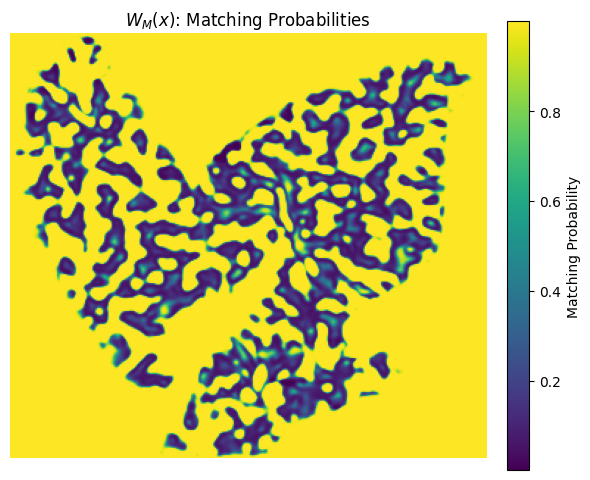

In [11]:
### Matching and Background Probabilities
WM = resu['WM'].cpu()
WB = resu['WB'].cpu()

W = torch.stack((WM,WB))
pi = torch.sum(W,dim=(1,2))
pi += torch.max(pi)*1e-6
pi /= torch.sum(pi)
print('Matching probabilities:', pi)

fig,ax = plt.subplots(figsize = (6,5))
im = ax.imshow(WM)
ax.set_title(r'$W_M(x)$: Matching Probabilities')
ax.axis('off')
ax.invert_yaxis()
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Matching Probability')  

plt.tight_layout()
plt.show()

In this experiment, we visualise the diffeomorphic mapping $\phi^v(A(x))$ from source to target,   as well as its inverse $(\phi^v(A(x)))^{-1}$, which maps the target back to the source.  
These mappings illustrate how GALA smoothly deforms one cell-resolved replicate onto the other while preserving spatial coherence.

In [12]:
from GALA.utils import build_transform, transform_image_source_to_target,transform_image_target_to_source
### Phi mapping: source to target
xv = resu['xv']
v = resu['v']
A = resu['A']
xI = [YI,XI]
xJ = [YJ,XJ]
xI = [torch.as_tensor(x,device = 'cpu') for x in xI]
xJ = [torch.as_tensor(x,device = 'cpu') for x in xJ]
def extent_from_x(xJ):
    dJ = [x[1]-x[0] for x in xJ]
    extentJ = ( (xJ[1][0] - dJ[1]/2.0).item(),
               (xJ[1][-1] + dJ[1]/2.0).item(),
               (xJ[0][-1] + dJ[0]/2.0).item(),
               (xJ[0][0] - dJ[0]/2.0).item())
    return extentJ

### Forward
phii = build_transform(xv,v,A,torch.stack(torch.meshgrid(*xJ,indexing='ij'),-1))
aI = I[3]
aI = aI[None,...]
phiI = transform_image_source_to_target(xv,v,A,xI,aI,torch.stack(torch.meshgrid(*xJ,indexing='ij'),-1))
extentJ = extent_from_x((YJ,XJ))

###
### Backwards
###
phij = build_transform(xv,v,A,torch.stack(torch.meshgrid(*xI,indexing='ij'),-1),forward  = True)  
aJ = J[3]
aJ = aJ[None,...]
phiJ = transform_image_target_to_source(xv,v,A,xJ,aJ,torch.stack(torch.meshgrid(*xI,indexing='ij'),-1))
extentI = extent_from_x((YI,XI))


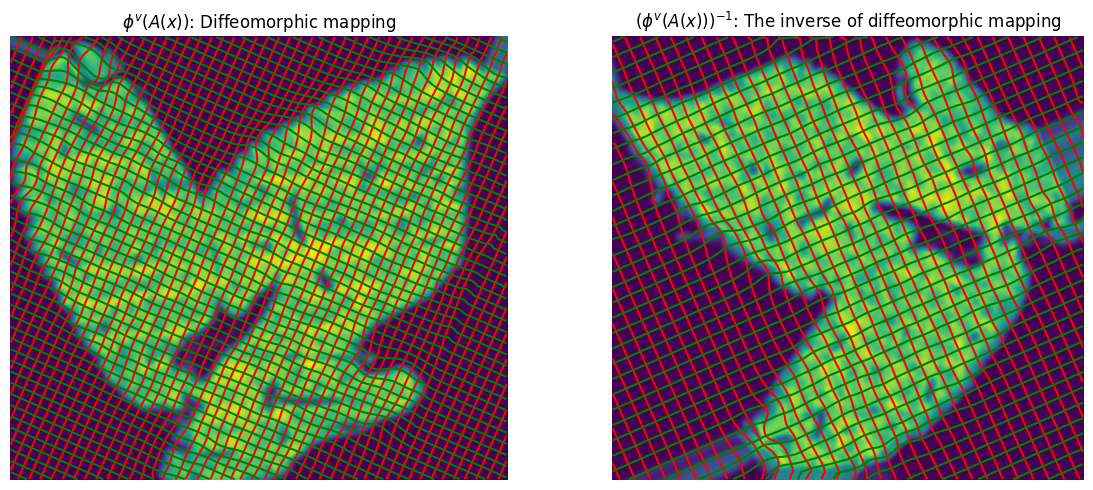

In [13]:
fig,ax = plt.subplots(1,2,figsize=(12, 5))
# Forward diffeomorphic mapping: source -> target 
ax[0].contour(XJ,YJ,phii[...,0],colors='r',linestyles='-',
            levels= np.arange( phii.min(), phii.max(), 200)  )
ax[0].contour(XJ,YJ,phii[...,1],colors='g',linestyles='-',
           levels= np.arange( phii.min(), phii.max(), 200))
ax[0].imshow(phiI.permute(1,2,0)/torch.max(phiI),extent = extentJ)
ax[0].set_title(r'$\phi^v(A(x))$: Diffeomorphic mapping')
ax[0].axis('off')
ax[0].invert_yaxis()

# Inverse diffeomorphic mapping: target -> source
ax[1].contour(XI,YI,phij[...,0],colors='r',linestyles='-',
            levels = np.arange(phij.min(), phij.max(), 300) )
ax[1].contour(XI,YI,phij[...,1],colors='g',linestyles='-',
           levels = np.arange(phij.min(), phij.max(), 300))
ax[1].imshow(phiJ.permute(1,2,0)/torch.max(phiJ),extent = extentI)
ax[1].set_title(r'$(\phi^v(A(x)))^{-1}$: The inverse of diffeomorphic mapping')
ax[1].axis('off')
ax[1].invert_yaxis()


plt.tight_layout()
plt.show()
